# Basic Data Analysis of GB1900

TODO:

- [ ] Histogram 2D using geopandas
- [ ] Legend beautification
- [ ] local_authority labels on the maps (when hover over them)
- [ ] change basemap to exclude Northern Ireland
- [ ] query maps based on lat/lon of pins, possibly add a new column with link to sheets
- [ ] abbreviation disambiguation ---> remove dots (in search/string matching step)

In [1]:
# %matplotlib notebook 

## Read the Gazetteer (gb1900_gazetteer_complete_july_2018.csv)

In [2]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd

In [3]:
with open("./gb1900_gazetteer_complete_july_2018.csv", encoding='UTF-16') as f:
    df = pd.read_csv(f)

/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print("#items: ", len(df))
df.head()

#items:  2552459


,pin_id,final_text,nation,local_authority,parish,osgb_east,osgb_north,latitude,longitude,notes
0,52b34d8b695fe90005004e1e,F. P.,Wales,Powys,Llansilin,320836.712742,327820.182715,52.842050,-3.176744,NaN
1,5800a6b92c66dcab3d061796,Parly. & Munl Boro. By.,England,City of London,NaN,531794.825962,180705.741898,51.509918,-0.102246,NaN
2,5800a6782c66dcab3d061786,S. Ps.,England,City of London,NaN,531736.217116,180725.027730,51.510105,-0.103083,NaN
3,57f684f42c66dcab3d01c0dd,Southwark Bridge Stairs,England,City of London,NaN,532199.584123,180696.934434,51.509744,-0.096420,NaN
4,57f685002c66dcab3d01c0e9,St. Paul's Pier,England,City of London,NaN,531987.486097,180745.664556,51.510232,-0.099456,NaN


## Find and group unique text strings

In [5]:
min_counts = 5000
xy2plot = df.groupby("final_text").count().sort_values("pin_id", ascending=False)["pin_id"]
xy2plot_filtered = xy2plot[xy2plot > min_counts]
print("Total number of unique text strings: {}".format(len(xy2plot)))
print("Number of unique text strings (after filtering): {}".format(len(xy2plot_filtered)))

Total number of unique text strings: 692648
Number of unique text strings (after filtering): 30


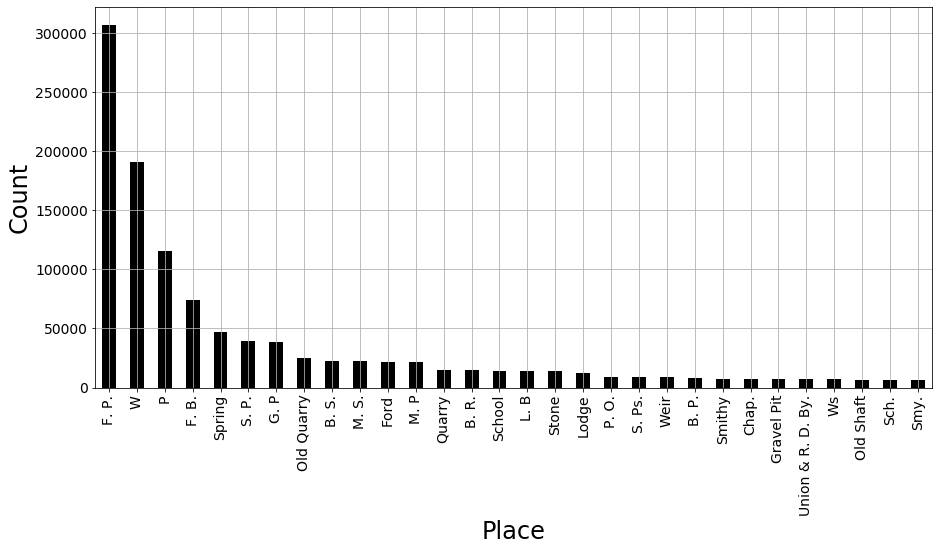

In [6]:
ax = plt.figure(figsize=(15, 7)).add_subplot(111)
xy2plot_filtered.plot(ax=ax, kind='bar', color='k')
ax.set_xlabel("Place", size=24)
ax.set_ylabel("Count", size=24)
ax.tick_params(labelsize=14)
ax.grid()
plt.show()

In [7]:
# list text/number of xy2plot_filtered
first_index = 0
last_index = 50
xy2plot_filtered[first_index:last_index]

final_text
F. P.                306583
W                    190979
P                    115877
F. B.                 74514
Spring                46876
S. P.                 39571
G. P                  38842
Old Quarry            24673
B. S.                 22363
M. S.                 22161
Ford                  21926
M. P                  21241
Quarry                15042
B. R.                 14891
School                14351
L. B                  14279
Stone                 13625
Lodge                 12661
P. O.                  9030
S. Ps.                 8841
Weir                   8840
B. P.                  8528
Smithy                 7330
Chap.                  7177
Gravel Pit             7029
Union & R. D. By.      6887
Ws                     6868
Old Shaft              6436
Sch.                   6422
Smy.                   6189
Name: pin_id, dtype: int64

In [8]:
# one instance with longitude < -10
df[df["longitude"] < -10]

,pin_id,final_text,nation,local_authority,parish,osgb_east,osgb_north,latitude,longitude,notes
1045410,57f2d91b2c66dcab3d005cae,Rockall,Scotland,Na H Eileanan An Iar,NaN,-296486.365838,916606.505261,57.596578,-13.688536,NaN


## Select texts/lables for further analysis/plotting

In [9]:
# read OS_Abbreviations.xlsx file which contains mapping between label and text
os_abbreviation = pd.read_excel("./OS_Abbreviations.xlsx")

search_string = "line"
list_of_selected_text = os_abbreviation[os_abbreviation["text"].str.contains(search_string, 
                                                                             case=False, 
                                                                             na=False)].label.to_list()
list_of_selected_text.extend([search_string])
print("Here is the list of selected texts that contain {}: {}".format(search_string, list_of_selected_text))

for itext in list_of_selected_text:
    print(10*"=" + " {}".format(itext))
    df_filtered = df[df["final_text"].str.contains(itext, case=False, na=False)]
    print(df_filtered.groupby("final_text").count().sort_values("pin_id", ascending=False)["pin_id"][0:40])

Here is the list of selected texts that contain line: ['ETL', 'PL', 'RL', 'Tel Line', 'line']
========== ETL
final_text
L. & S. W. R. NETLEY & FAREHAM                              5
Wetlands                                                    4
Picketlaw                                                   3
Zetland Street                                              3
NETLEY ST.                                                  3
ZETLAND STREET                                              3
FETLAR                                                      2
Whetley Farm                                                2
Netley Farm                                                 2
ZETLAND ST.                                                 2
Wetlands Lane                                               2
Netley Lodge                                                2
DETLING                                                     2
Ketley Brook                                                2
Zetland rd. 

In [10]:
#1: each text/label is treated as an individual label
#2: combine list_of_selected_text
text_method = 1

# enter selected texts here
list_of_selected_text = ["School", "Sch."] #"Chap.", "Chapel"
# list_of_selected_text = ["Reading Room", "reading room", "S. E. R. READING BRANCH"] #"Chap.", "Chapel"
#list_of_selected_text = ["Cathedral"]

# list_of_selected_text = [#"MINERAL RAILWAY", 
#                          #"Mineral Railway",
#                          "GREAT WESTERN RAILWAY", 
#                          "Great Western Railway",
#                          "MIDLAND RAILWAY",
#                          "NORTH EASTERN RAILWAY",
#                          "LONDON & NORTH WESTERN RAILWAY",
#                          "GREAT EASTERN RAILWAY",
#                          "HIGHLAND RAILWAY",
                         
#                          "CALEDONIAN RAILWAY",
#                          "Caledonian Railway",
#                          "CHESHIRE LINES RAILWAY",
#                          "MIDLAND & GREAT NORTHERN JOINT RAILWAY",
                         
#                          #"Railway in course of construction",
#                          #"Abandoned Railway"
#                         ]

lats2plot = []
lons2plot = []
for i in list_of_selected_text:
    df_filtered = df[df["final_text"].isin([i])]
    print("'{}' has {} rows.".format(i, len(df_filtered)))
    lats2plot.append(df_filtered["latitude"].tolist())
    lons2plot.append(df_filtered["longitude"].tolist())

if text_method == 2:
    lats2plot = [list(itertools.chain.from_iterable(lats2plot))]
    lons2plot = [list(itertools.chain.from_iterable(lons2plot))]
    list_of_selected_text = [", ".join(list_of_selected_text)]    

'School' has 14351 rows.
'Sch.' has 6422 rows.


## GeoPandas for plotting

In [11]:
import geopandas as gpd
from shapely.geometry import Point

# Download shapefiles from earthworks.stanford.edu
world = gpd.read_file("./data_EPSG_4326/GBR_adm0.shp")

### Plot labels separately (text_method = 1)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


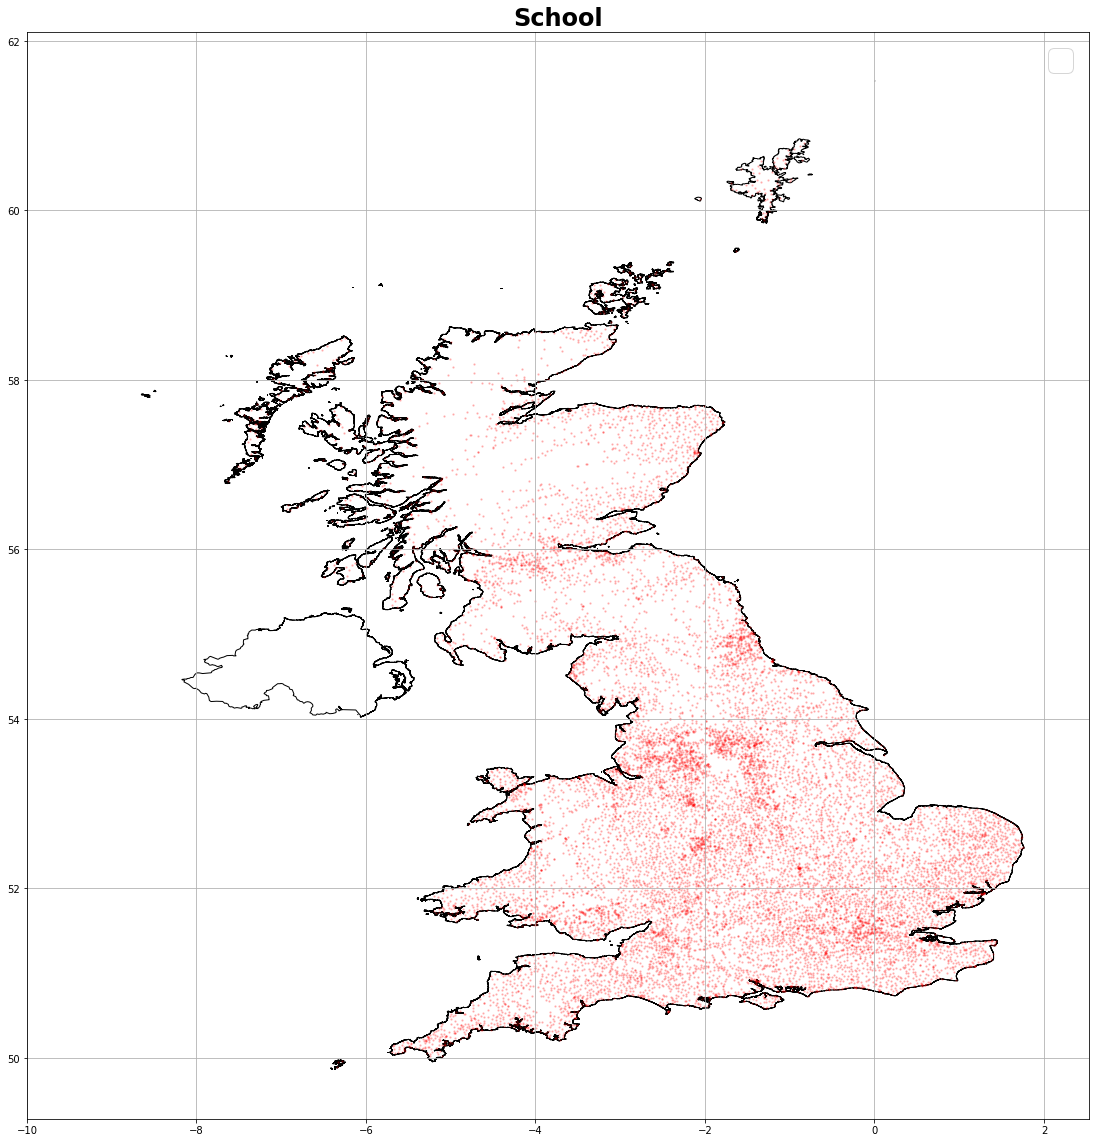

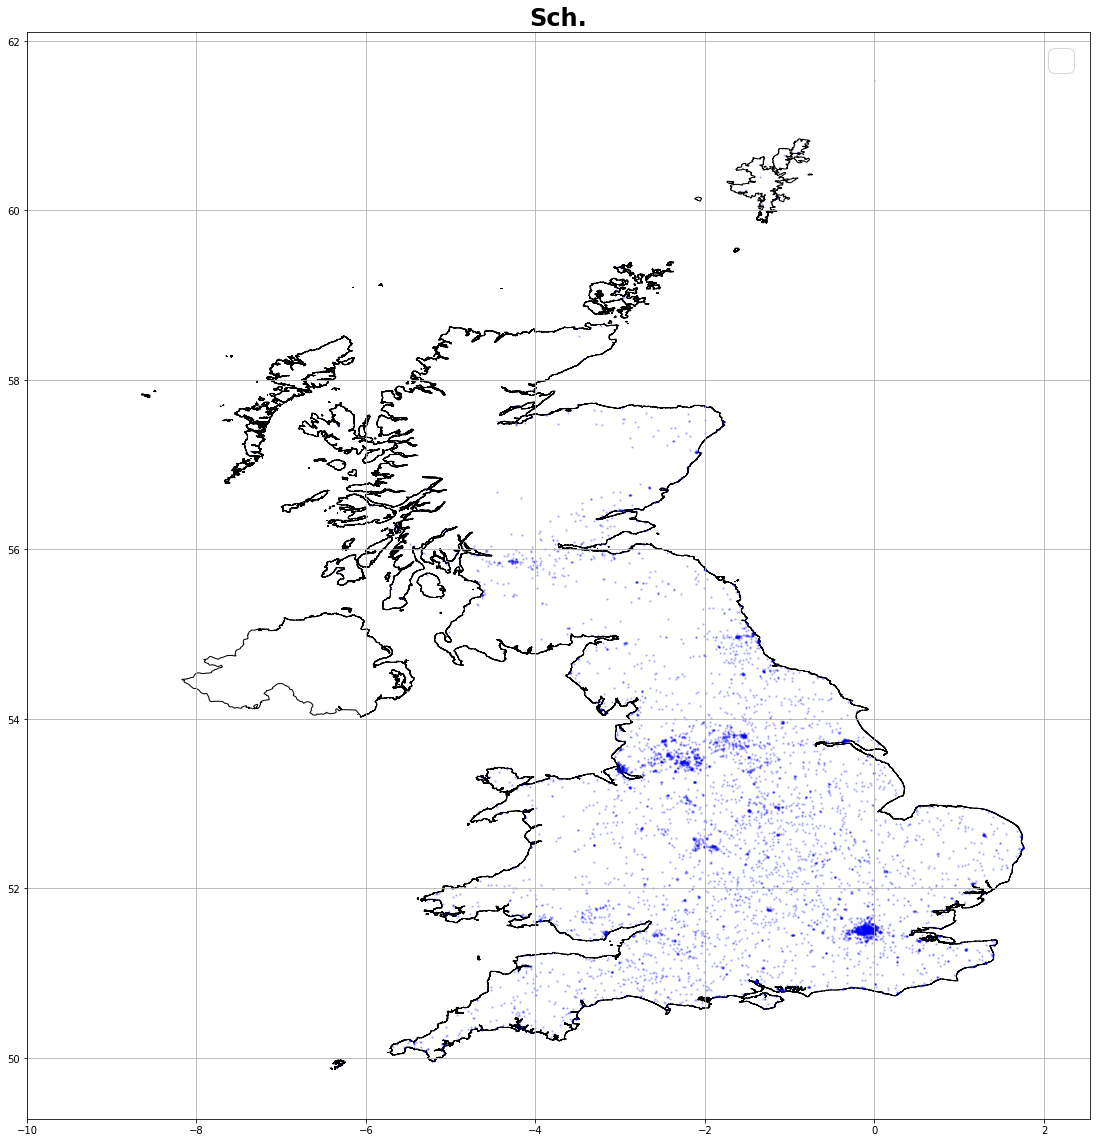

In [12]:
list_colors = 2*["r", "b", "g", "c", "m", "k"]

for igrp in range(len(lats2plot)):
    geometry = [Point(xy) for xy in zip(lons2plot[igrp], lats2plot[igrp])]
    gdf = gpd.GeoDataFrame(geometry=geometry)
    gdf.plot(ax=world.plot(figsize=(20, 20), edgecolor='k', color='none'), 
             marker='o', 
             color=list_colors[igrp], 
             markersize=2,
             alpha=0.2
            )
    plt.title(list_of_selected_text[igrp], size=24, weight='bold')
    plt.xlim(xmin=-10)
    plt.legend(prop={'size': 32})
    plt.grid()
plt.show()

In [13]:
list_of_selected_text

['School', 'Sch.']

### Plot labels together on one map (text_method = 1 or 2)

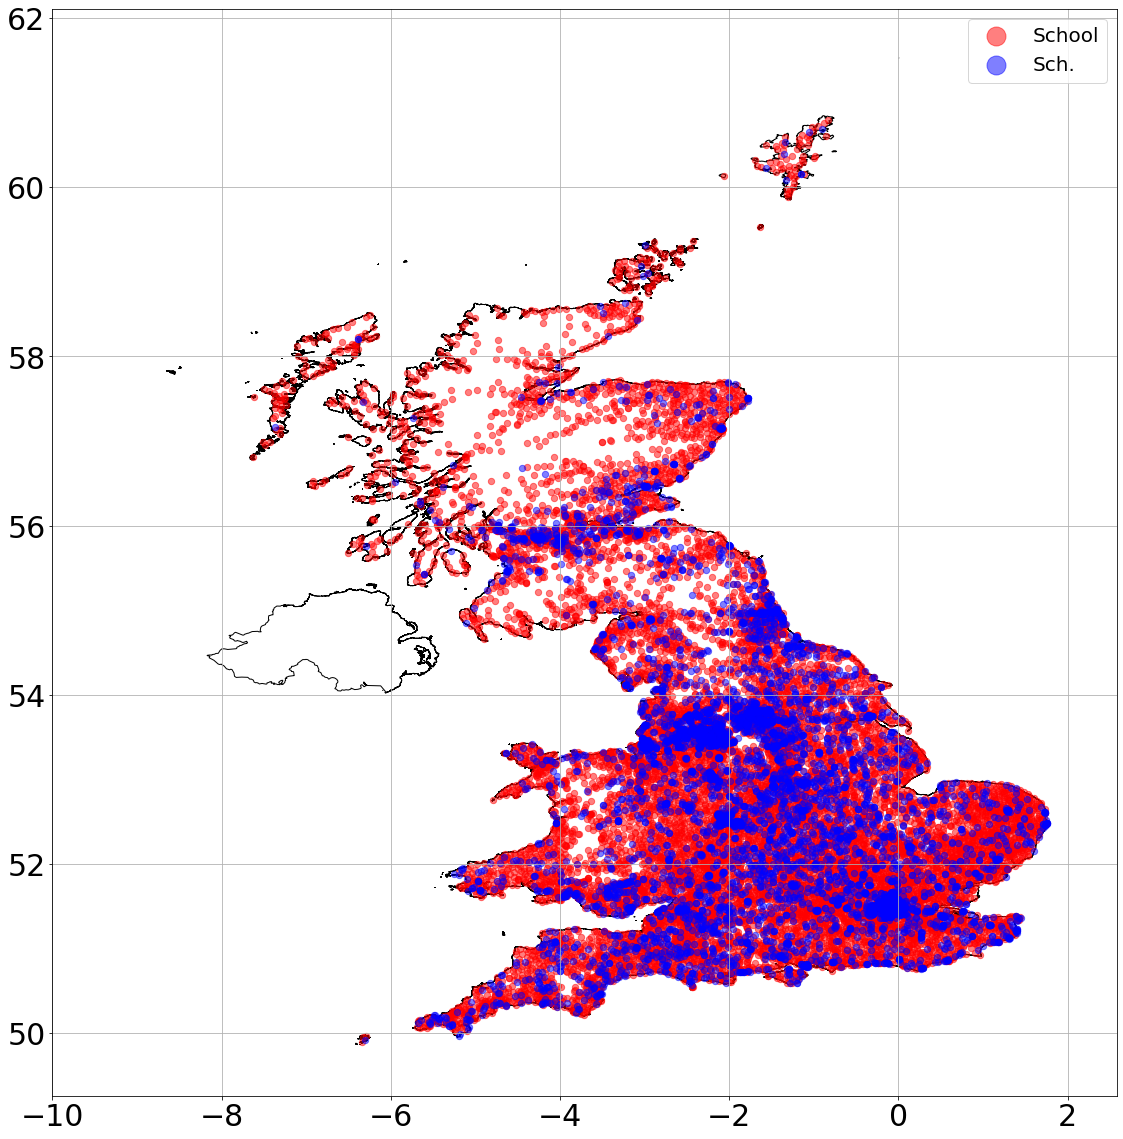

In [14]:
list_colors = 2*["r", "b", "g", "c", "m", "k"]

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

world.plot(ax=ax, edgecolor='k', color='none')

for igrp in range(len(lats2plot)):
    geometry = [Point(xy) for xy in zip(lons2plot[igrp], lats2plot[igrp])]
    gdf = gpd.GeoDataFrame(geometry=geometry)
    gdf.plot(ax=ax, 
             marker='o', 
             color=list_colors[igrp], 
             markersize=40,
             label=list_of_selected_text[igrp],
             alpha=0.5
            )
plt.xlim(xmin=-10)
plt.xticks(size=30)
plt.yticks(size=30)

plt.grid()
plt.legend(markerscale=3, prop={'size': 20})
plt.show()

### Simple plot (no projection)

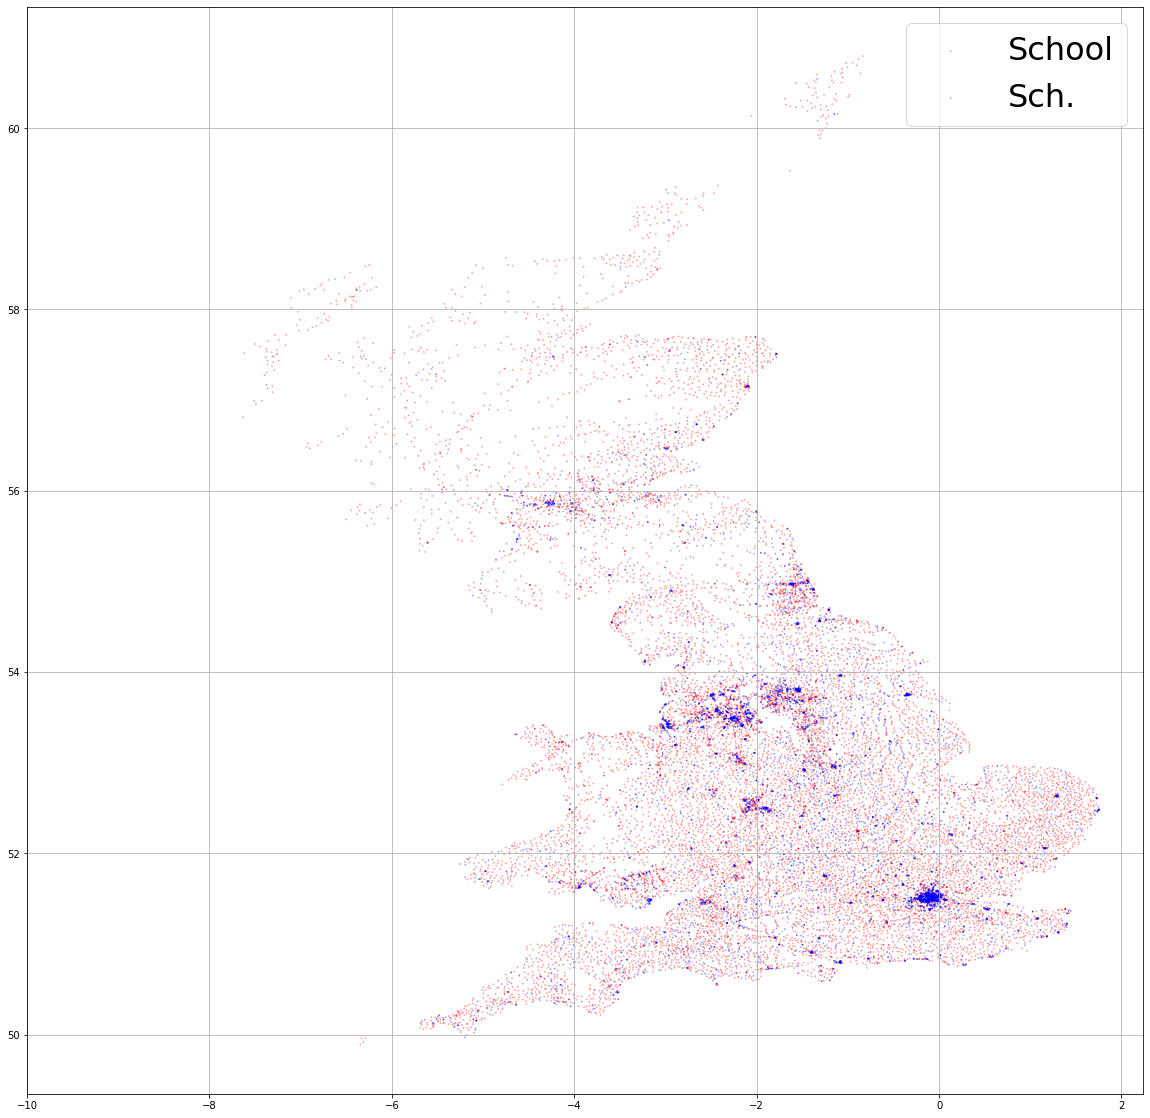

In [15]:
list_colors = ["r", "b", "g", "c", "m"]
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

for igrp in range(len(lats2plot)):
    plt.scatter(np.array(lons2plot[igrp]), 
            np.array(lats2plot[igrp]), 
            c=list_colors[igrp],
            s=3,
            edgecolors='none',
            alpha=0.4,
            label=list_of_selected_text[igrp])
    
plt.xlim(xmin=-10)
plt.grid()
plt.legend(prop={'size': 32})
plt.show()

## 2D Histograms

No handles with labels found to put in legend.


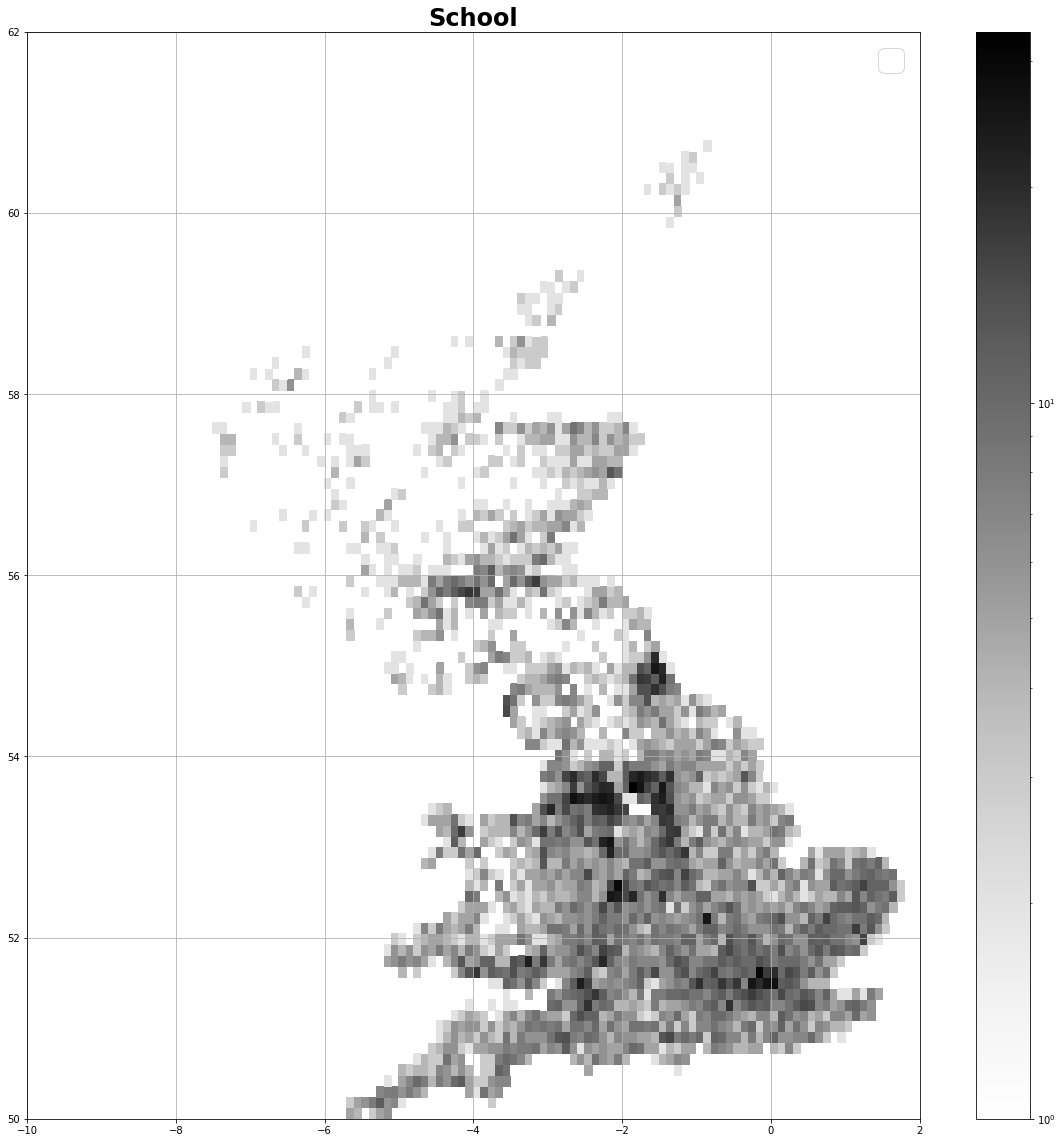

In [16]:
list_colors = ["r", "b", "g", "c", "m"]
plt.figure(figsize=(20, 20))

igrp = 0
plt.hist2d(np.array(lons2plot[igrp]), 
           np.array(lats2plot[igrp]),
           bins=(100, 100),
           range=[[-8, 2], [50, 62]],
           cmap="Greys",
           label=list_of_selected_text[igrp],
           #cmin=1,
           #cmax=100,
           norm=LogNorm()
          )

plt.title(list_of_selected_text[igrp], size=24, weight='bold')
plt.xlim(xmin=-10)
plt.legend(prop={'size': 32})
plt.colorbar()
plt.grid()
plt.show()

## Simple statistical analysis

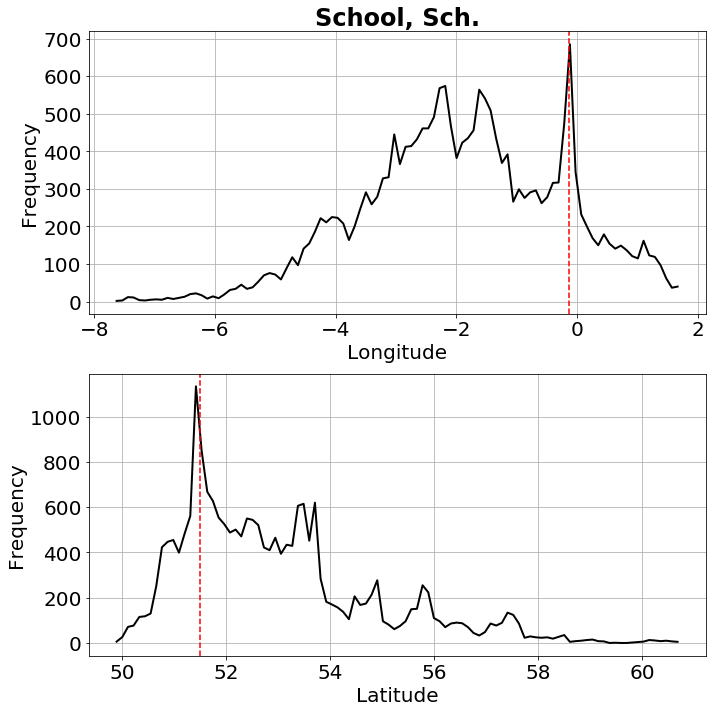

In [17]:
x_bin = 100
y_bin = 100

igrp = 0
hist_map = np.histogram2d(np.hstack([lons2plot[0], lons2plot[1]]), 
                          np.hstack([lats2plot[0], lats2plot[1]]), 
                          bins=(x_bin, y_bin))

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(hist_map[1][:-1], hist_map[0].sum(axis=1), lw=2, c='k')
plt.xticks(size=20)
plt.yticks(size=20)
plt.axvline(-0.13, 0, 1, ls='--', c='r')

plt.ylabel("Frequency", size=20)
plt.xlabel("Longitude", size=20)
plt.title("{}, {}".format(list_of_selected_text[0], list_of_selected_text[1]), size=24, weight='bold')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(hist_map[2][:-1], hist_map[0].sum(axis=0), lw=2, c='k')
plt.axvline(51.5, 0, 1, ls='--', c='r')
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel("Frequency", size=20)
plt.xlabel("Latitude", size=20)
plt.grid()

plt.tight_layout()

## Subtract two histograms

In [18]:
positive_list_selected_text = ["School", "Sch."]
negative_list_selected_text = ["Chap.", "Chapel"]
x_bin = 200
y_bin = 200
hist_range = [[-8, 2], [48, 62]]

# ============ positive
lats2plot = []
lons2plot = []
for i in positive_list_selected_text:
    df_filtered = df[df["final_text"].isin([i])]
    print("'{}' has {} rows.".format(i, len(df_filtered)))
    lats2plot.extend(df_filtered["latitude"].tolist())
    lons2plot.extend(df_filtered["longitude"].tolist())
lats2plot = [lats2plot]
lons2plot = [lons2plot]

hist_map_positive = np.histogram2d(np.array(lons2plot[0]), np.array(lats2plot[0]), 
                                   range=hist_range,
                                   bins=(x_bin, y_bin))

# ============ negative
lats2plot = []
lons2plot = []
for i in negative_list_selected_text:
    df_filtered = df[df["final_text"].isin([i])]
    print("'{}' has {} rows.".format(i, len(df_filtered)))
    lats2plot.extend(df_filtered["latitude"].tolist())
    lons2plot.extend(df_filtered["longitude"].tolist())
lats2plot = [lats2plot]
lons2plot = [lons2plot]

hist_map_negative = np.histogram2d(np.array(lons2plot[0]), np.array(lats2plot[0]), 
                                   range=hist_range,
                                   bins=(x_bin, y_bin))

'School' has 14351 rows.
'Sch.' has 6422 rows.
'Chap.' has 7177 rows.
'Chapel' has 2149 rows.


No handles with labels found to put in legend.


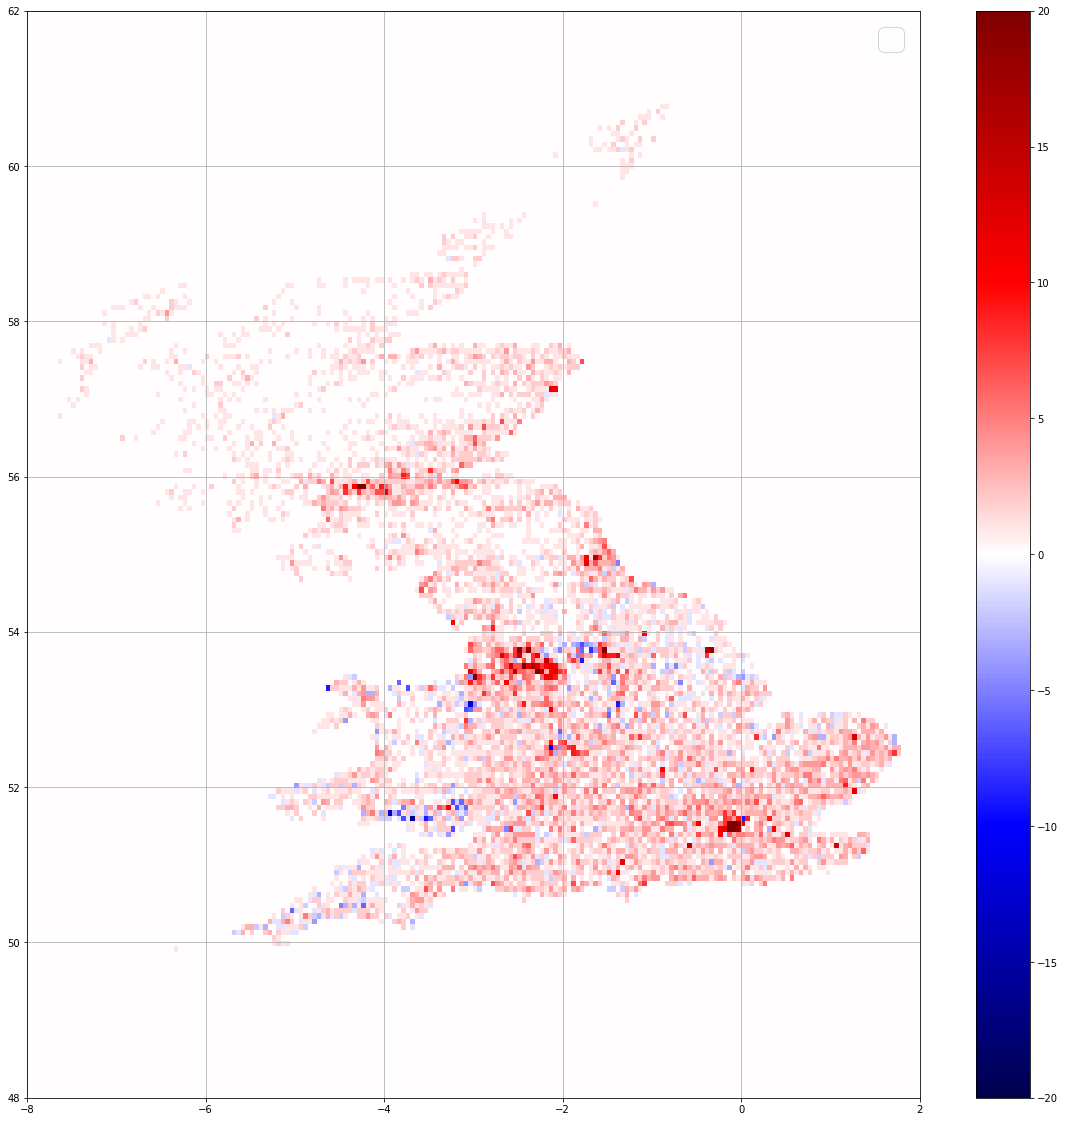

In [19]:
list_colors = ["r", "b", "g", "c", "m"]
plt.figure(figsize=(20, 20))

plt.pcolor(hist_map_positive[1], 
           hist_map_positive[2], 
           (hist_map_positive[0] - hist_map_negative[0]).T, 
           cmap="seismic",
           vmin=-20,
           vmax=20)
plt.xlim(xmin=hist_range[0][0], xmax=hist_range[0][1])
plt.ylim(ymin=hist_range[1][0], ymax=hist_range[1][1])
plt.legend(prop={'size': 32})
plt.colorbar()
plt.grid()
plt.show()

## create a KML file for the selected labels

In [20]:
# import simplekml

# list_colors = 2*[ 
#                  simplekml.Color.red,
#                  simplekml.Color.blue,
#                  simplekml.Color.green,
#                  simplekml.Color.cyan,
#                  simplekml.Color.magenta,
#                  simplekml.Color.black
#                 ]


# kml = simplekml.Kml()

# for i, iname in enumerate(list_of_selected_text):
#     df_filtered = df[df["final_text"].isin([iname])]
#     for j, jrow in df_filtered.iterrows():
#         pnt = kml.newpoint(
#             description="final_text:{}\nlocal_authority:{}\nparish:{}".format(jrow.final_text, jrow.local_authority, jrow.parish),
#             altitudemode="relativeToGround")#name='A Point')
#         #pnt.style.iconstyle.icon.href = '/Users/khosseini/myJobs/ATI/Projects/2019/Living-with-Machines-code/sources-lab-mro/linking/plot_on_google_earth/blue_circle.png'
#         #pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/rail.png'
#         #pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/schools.png'
#         #pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/paddle/red-circle.png'
#         pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/paddle/1.png'
#         pnt.style.iconstyle.icon.color = list_colors[i]
#         pnt.style.labelstyle.color = list_colors[i]
#         pnt.coords = [(jrow.longitude, jrow.latitude, 0)]
#         pnt.style.iconstyle.scale = 1.0
# kml.save("church.kml")

## create a KML file for all labels / filtered regionally

In [21]:
# import simplekml
# from tqdm import tnrange, tqdm_notebook

# list_colors = 2*[ 
#                  simplekml.Color.red,
#                  simplekml.Color.blue,
#                  simplekml.Color.green,
#                  simplekml.Color.cyan,
#                  simplekml.Color.magenta,
#                  simplekml.Color.black
#                 ]


# kml = simplekml.Kml()

# df_filtered = df[(df["longitude"] > -3.22) * 
#                  (df["longitude"] < -2.5) * 
#                  (df["latitude"] > 53.2) * 
#                  (df["latitude"] < 53.52) 
#                 ]
# print(len(df_filtered))

# counter = 0
# for j, jrow in tqdm_notebook(df_filtered.iterrows(), total=df_filtered.shape[0]):
#     counter += 1
#     #if counter > 10000:
#     #    break
#     pnt = kml.newpoint(
#         description="final_text:{}\nlocal_authority:{}\nparish:{}".format(jrow.final_text, jrow.local_authority, jrow.parish),
#         altitudemode="relativeToGround")#name='A Point')
#     #pnt.style.iconstyle.icon.href = '/Users/khosseini/myJobs/ATI/Projects/2019/Living-with-Machines-code/sources-lab-mro/linking/plot_on_google_earth/blue_circle.png'
#     #pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/rail.png'
#     #pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/schools.png'
#     #pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/paddle/red-circle.png'
#     pnt.style.iconstyle.icon.href = '/Users/khosseini/myJobs/ATI/Projects/2019/Living-with-Machines-code/sources-lab-mro/linking/plot_on_google_earth/blue_circle.png'
#     pnt.style.iconstyle.icon.color = list_colors[0]
#     pnt.style.labelstyle.color = list_colors[0]
#     pnt.coords = [(jrow.longitude, jrow.latitude, 0)]
#     pnt.style.iconstyle.scale = 0.5
# print("\nwriting output...")
# kml.save("all.kml")
